[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)

# State Schema

## Review

モジュール1では、基礎を固めました！私たちは以下のようなエージェントを構築しました： 

* `act` - モデルが特定のツールを呼び出す
* `observe` - ツールの出力をモデルに返す
* `reason` - モデルがツールの出力を推論して、次に何をすべきかを決定する
* `persist state` - メモリ内のチェックポインタを利用して、中断を伴う長時間の会話をサポートする

そして、LangGraph Studioでローカルに提供したり、LangGraph Cloudでデプロイする方法を紹介しました。

## Goals

このモジュールでは、ステート(state)とメモリ(memory)についてより深く理解していきます。

まず、ステートスキーマを定義するいくつかの方法を復習しましょう。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Schema

LangGraph の `StateGraph` を定義するとき、[state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) を使います。

ステートスキーマは、グラフが使用するデータの構造と型を表します。

全てのノードはそのスキーマと通信することが期待されています。

LangGraphはステートスキーマの定義方法を柔軟に変更することができ、これによって、様々なPythonの[型](https://docs.python.org/3/library/stdtypes.html#type-objects)やvalidationの方法に対応できます

## TypedDict

モジュール1で述べたように、Pythonの `typing` モジュールの `TypedDict` クラスを使うことができます。

これはキーとそれに対応する値の型を指定することができます。

しかし、これらは型ヒント(type hint)であることに注意してください。

これらは[mypy](https://github.com/python/mypy)のような静的型チェッカやIDEによって、コードが実行される前に型に関する潜在的なエラーを検出するために使用されます。

しかし、実行時には強制されません！


In [1]:
from typing_extensions import TypedDict

class HogeDictState(TypedDict):
    foo: str
    bar: str

より具体的な値の制約については、`Literal`型ヒントのようなものを使用できます。

ここでは、`mood`は 「happy」か 「sad」のどちらかのみです。


In [2]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

LangGraphで定義したstateクラス（例えばここでは`TypedDictState`）を`StateGraph`に渡すだけで使用することができます。

また、各stateのキーはグラフ内の 「チャンネル」と考えることができます。

モジュール1で説明したように、各ノードで指定されたキーや 「チャンネル 」の値を上書きします。


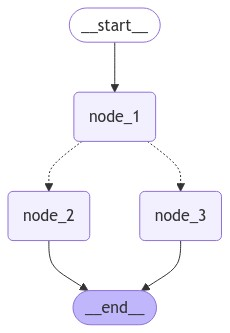

In [3]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Any

def node_1(state)-> dict[str, Any]:
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state) -> dict[str, str]:
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state) -> dict[str, str]:
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

state は dict なので、単純にdictでグラフを呼び出して、ステートに`name`キーの初期値を設定します。

In [4]:
graph.invoke({"name":"Lance"})

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Dataclass
Python の [dataclasses](https://docs.python.org/3/library/dataclasses.html) は [構造化データを定義する別の方法](https://www.datacamp.com/tutorial/python-data-classes) を提供します。

dataclasses は、主にデータを格納するために使われるクラスを作成するための簡潔な構文を提供します。

In [5]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]


`dataclass` のキーにアクセスするには、`node_1`で使用した添え字を変更するだけです： 

* 上記の`TypedDict`では`state["name"]`ではなく、`dataclass` の状態に対して`state.name`を使用しています。

少し奇妙なことにお気づきでしょう。各ノードでは状態の更新を行うために辞書を返しています。

これはLangGraphがステートオブジェクトが別々に各キーを保存しているからです。

ノードから返されるオブジェクトは、状態のキーと一致するキー（属性）を持っていればよいのです！

この場合、`dataclass`はキー`name`を持っているので、stateが`TypedDict`であったときと同じように、ノードからdictを渡すことで更新することができます。


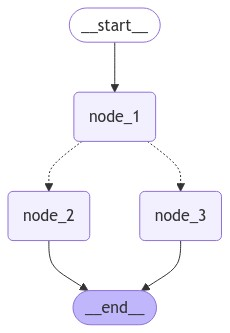

In [6]:
def node_1(state) -> dict[str, Any]:
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

`dataclass` を起動(invoke)して、各キー/チャンネルの初期値を設定します！

In [7]:
graph.invoke(DataclassState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Pydantic

前述のように、 `TypedDict` と `dataclasses` は型ヒント(type hint)を提供しますが、実行時に型を強制することはありません。

つまり、エラーを出さずに無効な値を代入できる可能性があります！

例えば、型ヒントは `mood: list[Literal["happy", "sad"]]` を指定しているにもかかわらず、引数`mood` に (happyやsadのかわりに) `mad` に指定できてしまいます。


In [9]:
# ホントはこの指定はできないほうがグラフの定義としては望ましい
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/)はPythonの型アノテーションを使ったデータのvalidationと設定管理ライブラリです。

Pydanticは検証機能を備えているため、[LangGraphでの状態スキーマの定義](https://langchain-ai.github.io/langgraph/how-tos/state-model/)に特に適しています。

Pydanticは、実行時にデータが指定された型や制約に適合しているかどうかの検証(validation)できます。


In [10]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: Literal["happy", "sad"]

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    # PydanticState のコンストラクタ呼び出し時にバリデーションが実行され、
    # happy or sad 以外は許可されていないので例外が発生する
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/literal_error


We can use `PydanticState` in our graph seamlessly. 

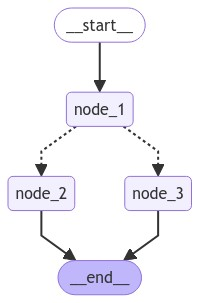

In [11]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}